In [1]:
# import modules
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import eli5
import xgbfir
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tqdm import tqdm
from collections import defaultdict

%matplotlib inline

In [2]:
# pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
train_df = pd.read_hdf('../data/train.hdf')
test_df = pd.read_hdf('../data/test.hdf')

In [3]:
train_df.shape, test_df.shape

((49658, 111), (16552, 110))

In [4]:
train_df.describe()

,us_id,target,age,var1,var2,var3,var4,var5,var6,var7,...,var119,var120,var121,var123,var127,var128,var129,var130,var131,gender
count,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,...,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000,49658.000000
mean,41623.850638,0.161787,33.195074,0.066978,0.021366,58.965142,0.026380,0.012848,0.240988,0.635366,...,0.216743,0.039248,0.007088,0.136656,0.046454,0.113763,0.063052,0.212059,0.034813,0.525092
std,23861.479529,0.368259,22.075192,0.249987,0.144603,30.191462,0.160266,0.112619,0.734879,1.765250,...,0.952485,0.194187,0.083895,0.541461,0.595802,0.657156,0.585429,0.627159,0.597037,0.499375
min,100.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,21056.000000,0.000000,20.000000,0.000000,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.184411,0.145081,-1.000000,0.111134,0.239328,0.095306,0.000000
50%,41635.500000,0.000000,37.000000,0.000000,0.000000,64.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.271587,0.233692,0.435556,0.188499,0.364284,0.203919,1.000000
75%,62270.500000,0.000000,50.000000,0.000000,0.000000,85.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.460872,0.424210,0.536328,0.445182,0.678497,0.422006,1.000000
max,82860.000000,1.000000,98.000000,1.000000,1.000000,100.000000,1.000000,1.000000,7.000000,7.000000,...,85.000000,1.000000,1.000000,0.765660,0.716565,0.841014,0.800885,0.826743,0.821522,1.000000


In [5]:
test_df.describe()

,us_id,age,var1,var2,var3,var4,var5,var6,var7,var8,...,var119,var120,var121,var123,var127,var128,var129,var130,var131,gender
count,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,...,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.000000,16552.00000
mean,41184.065672,33.329809,0.064645,0.022112,59.220517,0.026160,0.012446,0.249094,0.637023,4.388956,...,0.203782,0.033470,0.008156,0.138697,0.049399,0.105278,0.063150,0.212702,0.037657,0.53057
std,23984.111703,21.985460,0.245905,0.147053,30.178709,0.159616,0.110867,0.767756,1.765225,29.702694,...,0.788322,0.179867,0.089945,0.541706,0.594632,0.661716,0.585536,0.626756,0.596869,0.49908
min,101.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.00000
25%,20217.500000,20.000000,0.000000,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.186542,0.145157,-1.000000,0.111134,0.239433,0.095306,0.00000
50%,41177.000000,38.000000,0.000000,0.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.272237,0.236136,0.431508,0.191315,0.363909,0.206013,1.00000
75%,62026.500000,50.000000,0.000000,0.000000,86.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.466793,0.430545,0.533681,0.446567,0.676714,0.425794,1.00000
max,82861.000000,97.000000,1.000000,1.000000,100.000000,1.000000,1.000000,7.000000,7.000000,1145.000000,...,17.000000,1.000000,1.000000,0.765660,0.716565,0.840319,0.800885,0.826743,0.821522,1.00000


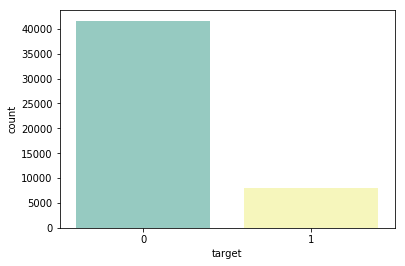

In [6]:
# distribution of target variable in train dataset
sns.countplot(train_df['target'], palette='Set3');

In [7]:
width = 10
precision = 4
value = (100 * train_df['target'].value_counts()[1] / train_df.shape[0])
print(
    f"There are: {value:{width}.{precision}}% target values with 1")      

There are:      16.18% target values with 1


### Data is unbalanced with respect with target value

In [8]:
# [2:] to omit 'us_id', 'target' columns
features = train_df.columns.values[2:]

`Distribution of skew and kurtosis`

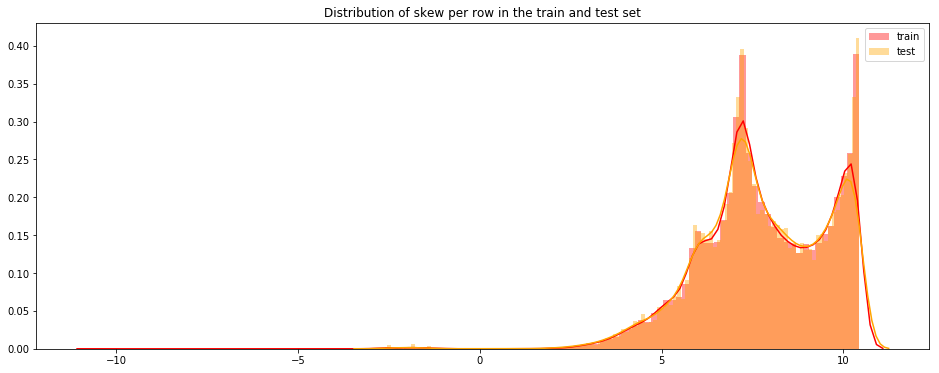

In [9]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),
             color="red", kde=True, bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),
             color="orange", kde=True, bins=120, label='test')
plt.legend()
plt.show()

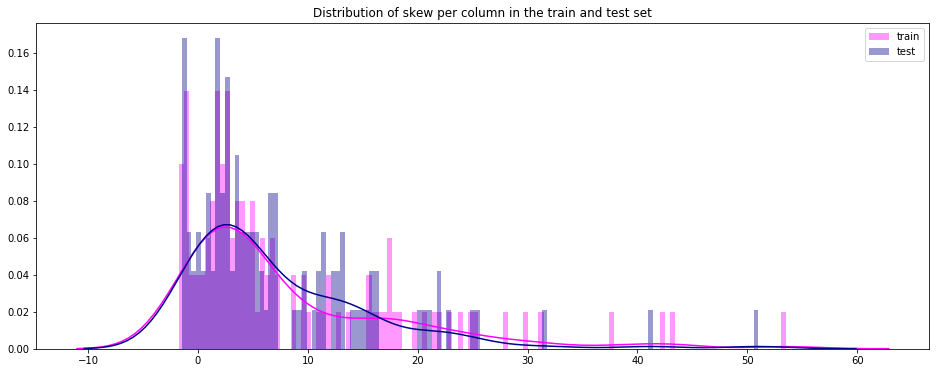

In [11]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),
             color="magenta", kde=True, bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),
             color="darkblue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

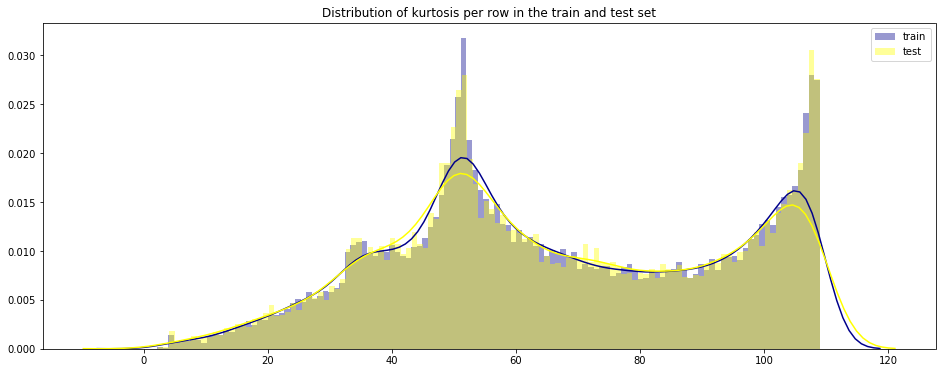

In [12]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),
             color="darkblue", kde=True, bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),
             color="yellow", kde=True, bins=120, label='test')
plt.legend()
plt.show()

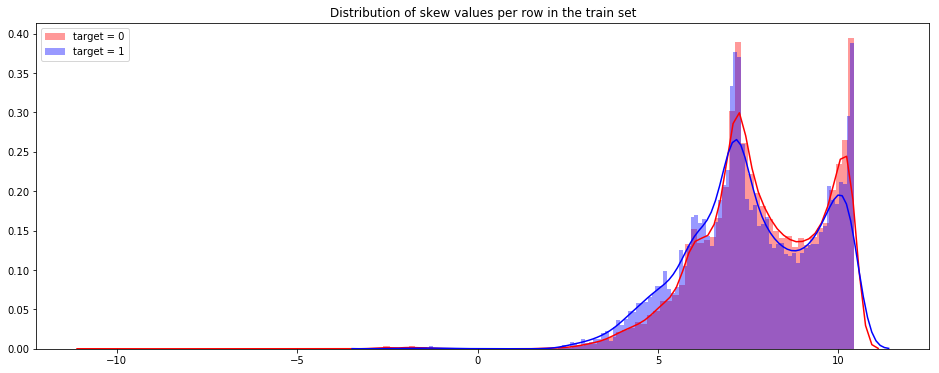

In [13]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16, 6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1), color="red",
             kde=True, bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1), color="blue",
             kde=True, bins=120, label='target = 1')
plt.legend()
plt.show()

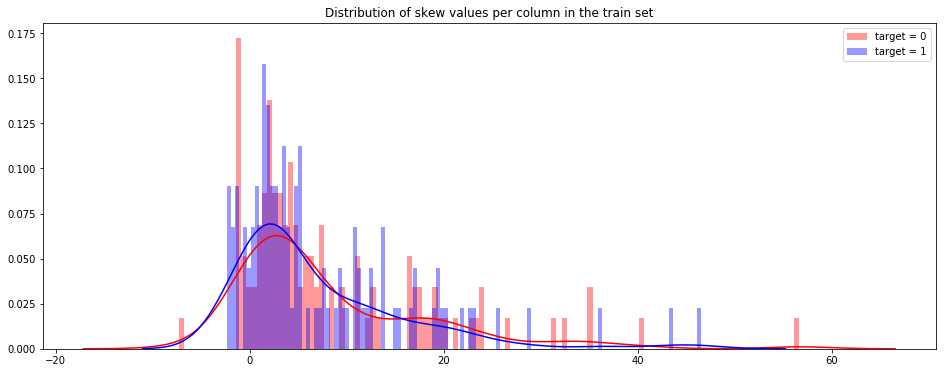

In [14]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16, 6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0), color="red",
             kde=True, bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0), color="blue",
             kde=True, bins=120, label='target = 1')
plt.legend()
plt.show()

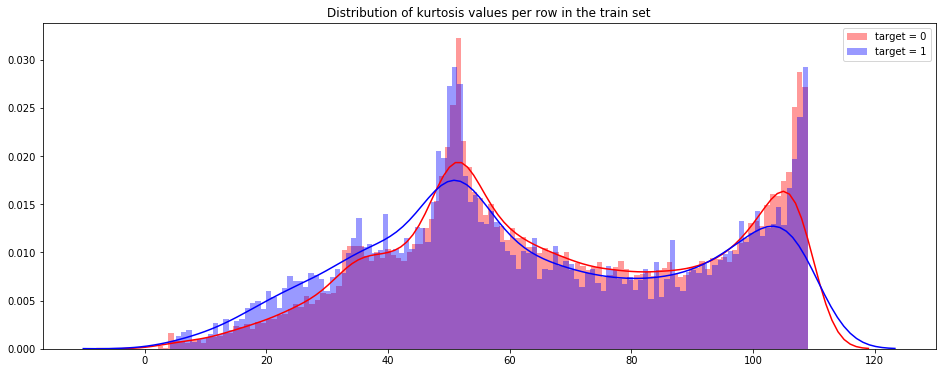

In [15]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16, 6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1), color="red",
             kde=True, bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1), color="blue",
             kde=True, bins=120, label='target = 1')
plt.legend()
plt.show()

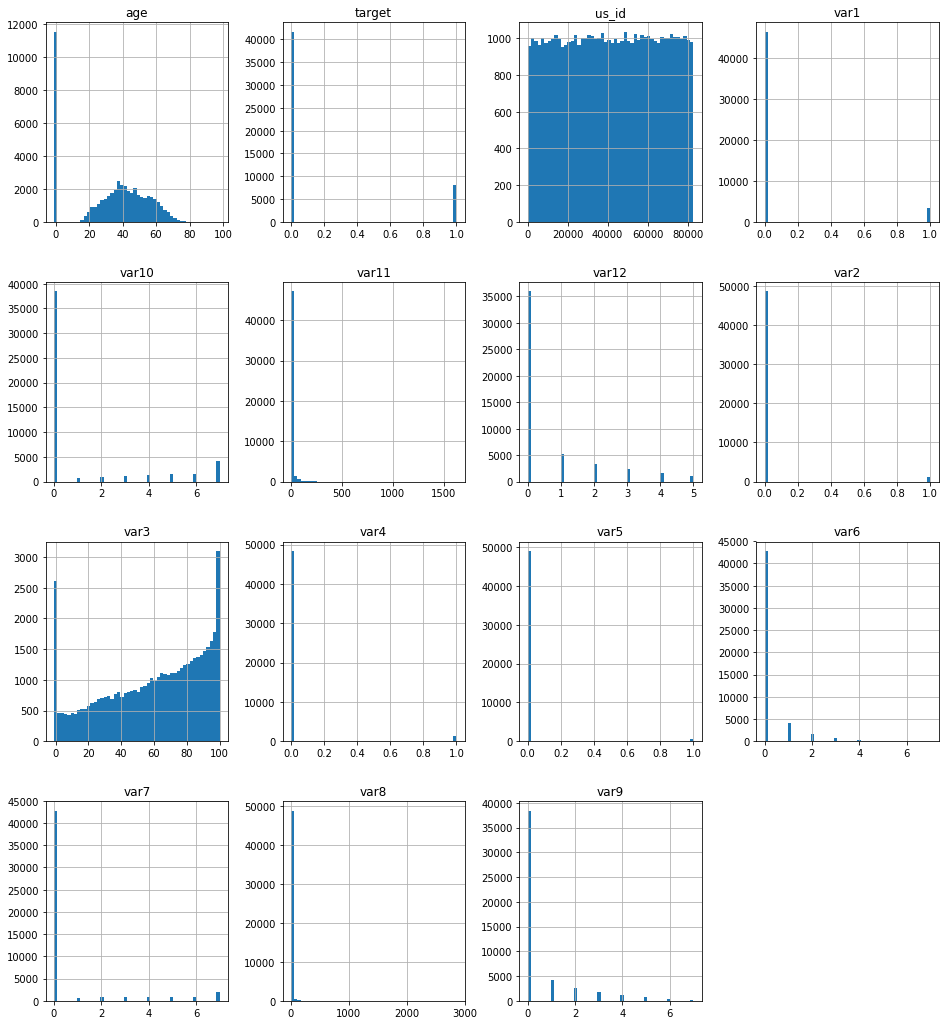

In [19]:
train_df.iloc[:, :15].hist(figsize=(16, 18), bins=50);

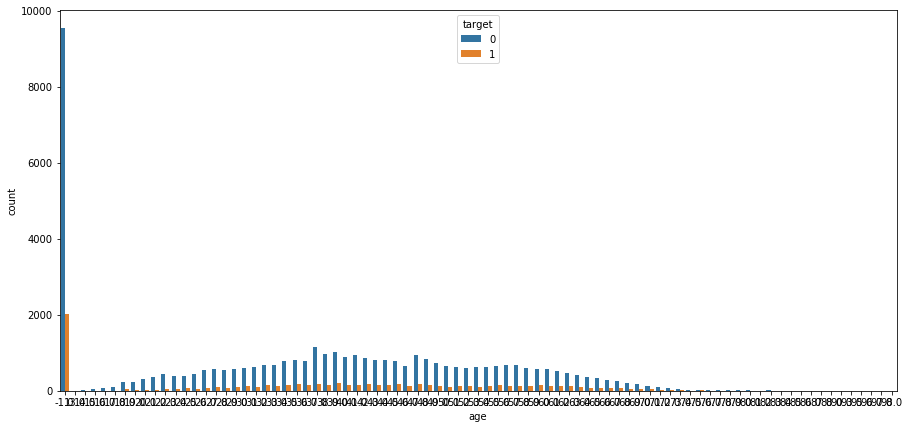

In [20]:
plt.figure(figsize=(15, 7))
sns.countplot(x="age", hue="target", data=train_df);

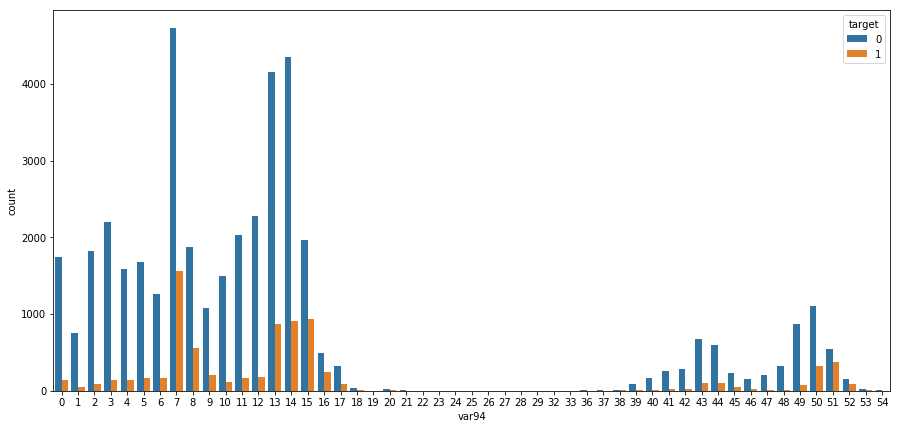

In [21]:
plt.figure(figsize=(15, 7))
sns.countplot(x="var94", hue="target", data=train_df);

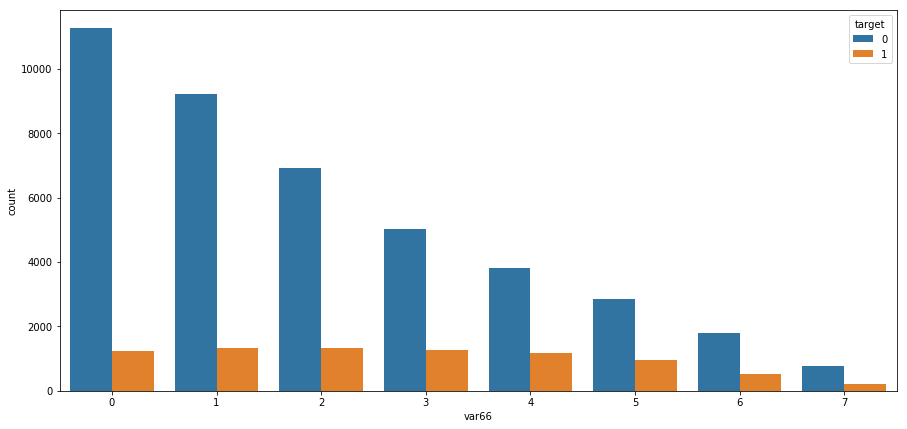

In [22]:
plt.figure(figsize=(15, 7))
sns.countplot(x="var66", hue="target", data=train_df);

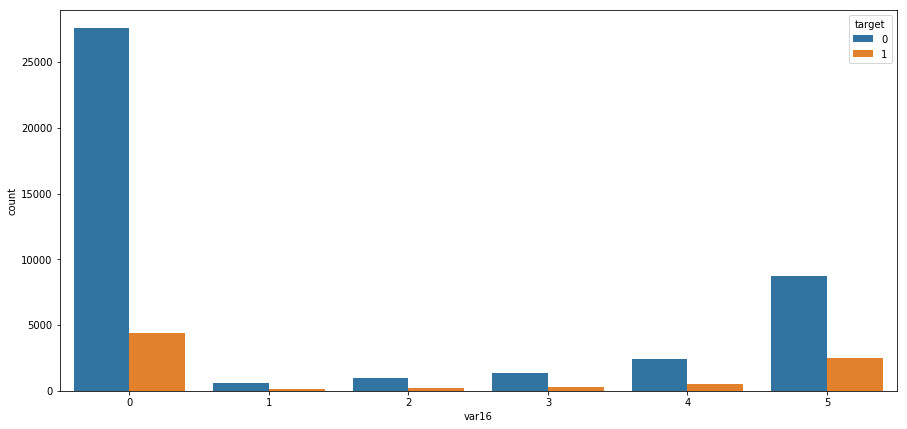

In [23]:
plt.figure(figsize=(15, 7))
sns.countplot(x="var16", hue="target", data=train_df);

## Basic model

In [10]:
X = train_df['age'].values
y = train_df['target'].values

model = DummyClassifier()
model.fit(X, y)
y_pred = model.predict(X)

roc_auc_score(y, y_pred)

0.5006782778275933

# At the beggining basic model scored 0.50 roc_auc

In [53]:
# drop ID and target from columns list to form features list
features = [column for column in train_df.columns if column not in [
    'us_id', 'target']]

`Picked StratifiedKFold to validate model. StratifiedKFold ensures that answers on each iteration will have the same distribution.`

In [11]:
def cv_model(model, X, y, n_splits=3):
    """
    get scikit-learn api. 
    :param model: choose model instance
    :param X: matrix
    :param y: vector
    :param n_splits: number of splitting iterations in the cross-validator
    :return: mean, std list of scores
    """
    scores = []
    cv = StratifiedKFold(n_splits=n_splits, random_state=669, shuffle=True)

    for train_idx, test_idx in cv.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]

        scores.append(roc_auc_score(y[test_idx], y_pred))
        
    return np.mean(scores), np.std(scores)

In [55]:
X = train_df[features].values
y = train_df['target'].values

## LogisticRegression

In [10]:
%time cv_model(LogisticRegression(solver="liblinear", penalty="l2", C=1.0), X, y)

/home/wojtek_felix_zuber/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/wojtek_felix_zuber/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/wojtek_felix_zuber/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/wojtek_felix_zuber/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CPU times: user 59.8 s, sys: 123 ms, total: 59.9 s
Wall time: 59.3 s


/home/wojtek_felix_zuber/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(0.633391221145594, 0.03484297916221039)

## DecisionTreeClassifier

In [11]:
%time cv_model(DecisionTreeClassifier(max_depth=5), X, y)

CPU times: user 3.15 s, sys: 136 ms, total: 3.29 s
Wall time: 3.36 s


(0.6635361390598801, 0.005164870608604904)

## RandomForestClassifier

In [12]:
%time cv_model(RandomForestClassifier(max_depth=10, n_estimators=20), X, y)

CPU times: user 7.66 s, sys: 75.9 ms, total: 7.74 s
Wall time: 7.74 s


(0.6707493559861314, 0.008345006132340878)

# XGBoost

In [56]:
xgb_params = {
    'eval_metric': 'aucpr',
    'max_depth': 3,
    'n_estimators': 80,
    'learning_rate': 0.2,
    'seed': 669,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

In [57]:
%time cv_model(xgb.XGBClassifier(**xgb_params), X, y)

CPU times: user 22.1 s, sys: 91.9 ms, total: 22.2 s
Wall time: 22.2 s


(0.7215897542692581, 0.00448661257347762)

# Took data for a spin with LogisticRegression, DecisionTreeClassifier, RandomForestClassifier and XGBClassifier to find out that xgb scores best

`Learning Curve is a tool, which helps detecting if overfitting took place.`

In [58]:
model = xgb.XGBClassifier(**xgb_params)
model.fit(X, y)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eval_metric='aucpr',
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=669,
       silent=None, subsample=0.8, verbosity=1)

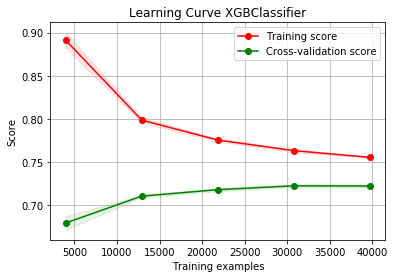

In [59]:
skplt.estimators.plot_learning_curve(model, X, y, cv=5, random_state=669,
                                     shuffle=True, scoring='roc_auc',
                                     title="Learning Curve XGBClassifier");

# XGB + Learning Curve, iterations on x axis(iteration means adding another model, implicit "tree".)

[0]	validation_0-error:0.161788	validation_1-error:0.161783
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 12 rounds.
[20]	validation_0-error:0.158677	validation_1-error:0.158582
Stopping. Best iteration:
[27]	validation_0-error:0.15771	validation_1-error:0.157857

{'validation_0': {'error': [0.161788, 0.161184, 0.161698, 0.161698, 0.161698, 0.161698, 0.161184, 0.161154, 0.161214, 0.160973, 0.161003, 0.16061, 0.16055, 0.160308, 0.160127, 0.160217, 0.159885, 0.159493, 0.158979, 0.158737, 0.158677, 0.158526, 0.158375, 0.158163, 0.158194, 0.157982, 0.157771, 0.15771, 0.157589, 0.157589, 0.15771, 0.157559, 0.157408, 0.157287, 0.157257, 0.157227, 0.157046, 0.156593, 0.156472]}, 'validation_1': {'error': [0.161783, 0.161481, 0.161783, 0.161783, 0.161783, 0.161783, 0.161179, 0.16124, 0.161179, 0.160756, 0.160877, 0.159971, 0.15985, 0.159488, 0.159548, 0.159488, 0.159548, 0.159306, 0.158642, 

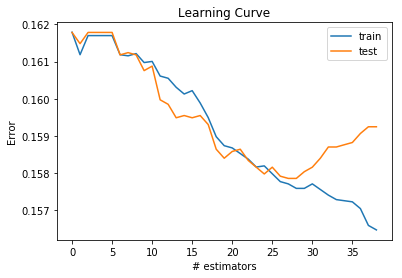

[0]	validation_0-error:0.161184	validation_1-error:0.161542
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 12 rounds.
[20]	validation_0-error:0.159009	validation_1-error:0.159971
[40]	validation_0-error:0.157348	validation_1-error:0.158944
Stopping. Best iteration:
[36]	validation_0-error:0.157559	validation_1-error:0.158702

{'validation_0': {'error': [0.161184, 0.161335, 0.161245, 0.161245, 0.161275, 0.161275, 0.160973, 0.16052, 0.160822, 0.160459, 0.160459, 0.16058, 0.160369, 0.159885, 0.159613, 0.159674, 0.159795, 0.159674, 0.159462, 0.159009, 0.159009, 0.158888, 0.158677, 0.158617, 0.158586, 0.158405, 0.158496, 0.158556, 0.158405, 0.157982, 0.157952, 0.157861, 0.15765, 0.157589, 0.157529, 0.157408, 0.157559, 0.157499, 0.157408, 0.157499, 0.157348, 0.157076, 0.157016, 0.157257, 0.157197, 0.157197, 0.157197, 0.157076]}, 'validation_1': {'error': [0.161542, 0.161783, 0.161663, 0.161

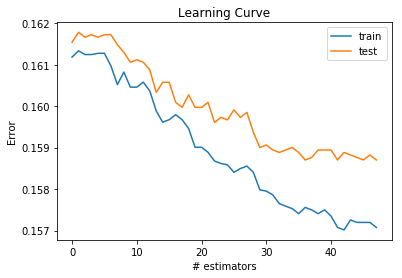

[0]	validation_0-error:0.161783	validation_1-error:0.161793
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 12 rounds.
[20]	validation_0-error:0.159004	validation_1-error:0.160102
[40]	validation_0-error:0.15695	validation_1-error:0.159014
[60]	validation_0-error:0.154896	validation_1-error:0.158229
[79]	validation_0-error:0.153386	validation_1-error:0.159074
Stopping. Best iteration:
[67]	validation_0-error:0.154413	validation_1-error:0.157987

{'validation_0': {'error': [0.161783, 0.1613, 0.161451, 0.161119, 0.16136, 0.160485, 0.160998, 0.161119, 0.160485, 0.160726, 0.160756, 0.160726, 0.160696, 0.160636, 0.160666, 0.160424, 0.159941, 0.159639, 0.159427, 0.159276, 0.159004, 0.158823, 0.158521, 0.158431, 0.15831, 0.158128, 0.157887, 0.157857, 0.157887, 0.157706, 0.157675, 0.157826, 0.157555, 0.157403, 0.157343, 0.157252, 0.157343, 0.157011, 0.156709, 0.15683, 0.15695, 0.156799, 0.1568

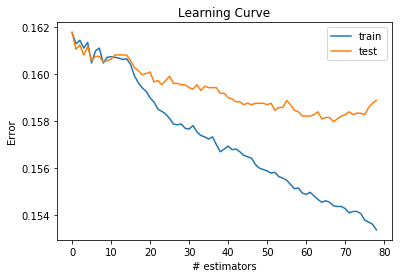

In [60]:
cv = StratifiedKFold(n_splits=3, random_state=669)

for train_idx, test_idx in cv.split(X, y):
    model = xgb.XGBClassifier(**xgb_params)
    # prepare eval_set
    eval_set = [
        (X[train_idx], y[train_idx]),
        (X[test_idx], y[test_idx])
    ]

    model.fit(X[train_idx], y[train_idx], eval_metric="error",
              eval_set=eval_set, verbose=20, early_stopping_rounds=12)
    # get evals result
    evals_result = model.evals_result()
    print(evals_result)
    print("")
    # plot
    plt.title("Learning Curve")
    plt.xlabel("# estimators")
    plt.ylabel("Error")
    plt.plot(model.evals_result_["validation_0"]["error"], label="train")
    plt.plot(model.evals_result_["validation_1"]["error"], label="test")
    plt.legend(loc="best")
    plt.show()

# Feature Engineering

In [ ]:
# train_df['age_minus_three'] = train_df['age'] - train_df['var3']

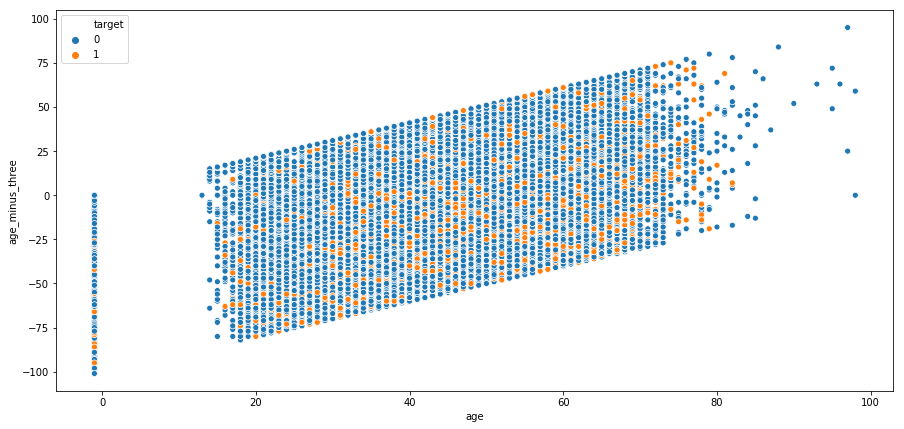

In [125]:
# plt.figure(figsize=(15, 7))
# sns.scatterplot(x="age", y="age_minus_three", hue='target', data=train_df);

In [ ]:
# idx = features = train_df.columns.values[2:202]
# for df in [test_df, train_df]:
#     df['sum'] = df[idx].sum(axis=1)  
#     df['min'] = df[idx].min(axis=1)
#     df['max'] = df[idx].max(axis=1)
#     df['mean'] = df[idx].mean(axis=1)
#     df['std'] = df[idx].std(axis=1)
#     df['skew'] = df[idx].skew(axis=1)
#     df['kurt'] = df[idx].kurtosis(axis=1)
#     df['med'] = df[idx].median(axis=1)

`Aggregated few features to the dataset, roc_auc decreased, it was a wrong idea. `

**Analyzed the failures, thought about it, then looked inside model via xgbfir and eli5. Based on feature interaction analysis, aggregated few features which improved roc_auc_score.**

In [22]:
xgbfir.saveXgbFI(model, feature_names=features,
                 OutputXlsxFile="feature_importance.xlsx")

In [23]:
pd.read_excel("feature_importance.xlsx", "Interaction Depth 2")

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,var94|var94|var94,2310.088839,14,6.282674,0.448762,165.006346,1377.128906,1,1,1,21,27,1,8.666667,17.071429,2
1,var15|var94|var94,792.896233,3,0.100345,0.033448,264.298744,29.082093,2,4,70,86,7,35,34.000000,7.333333,2
2,age|var94|var94,760.924649,8,3.549594,0.443699,95.115581,376.961396,3,2,2,22,39,2,11.666667,24.000000,2
3,var129|var52|var66,598.589905,2,0.640594,0.320297,299.294953,197.372943,4,6,17,32,6,3,11.333333,3.000000,2
4,var123|var94|var94,499.833751,3,0.169308,0.056436,166.611250,17.659274,5,5,56,80,26,51,37.166667,19.333333,2
5,var129|var94|var94,442.530411,2,0.586104,0.293052,221.265205,121.880745,6,7,20,36,12,6,14.500000,6.000000,2
6,var66|var94|var94,422.465488,4,0.799914,0.199978,105.616372,89.671355,7,3,13,47,36,9,19.166667,14.750000,2
7,var11|var94|var94,410.322273,2,0.347504,0.173752,205.161137,73.276737,8,8,35,50,18,11,21.666667,9.000000,2
8,var65|var66|var91,376.898193,1,0.334662,0.334662,376.898193,126.133602,9,22,39,31,1,5,17.833333,0.000000,2
9,var129|var41|var66,366.681718,1,0.171386,0.171386,366.681718,62.844058,10,23,54,52,2,15,26.000000,2.000000,2


In [61]:
eli5.show_weights(model.get_booster(), feature_names=features, top=10)

Weight,Feature
0.0576,var15
0.0479,var66
0.0422,var94
0.0379,var129
0.0375,var52
0.0334,var40
0.0257,var33
0.0254,var65
0.0223,var11
0.0188,var49


In [62]:
eli5.explain_weights_xgboost(
    model.get_booster(), feature_names=features, top=10, importance_type="cover")

Weight,Feature
0.0286,var114
0.0284,var86
0.0284,var87
0.0284,var95
0.0284,var42
0.0280,var119
0.0276,var103
0.0276,var110
0.0269,var1
0.0264,var84


In [63]:
eli5.explain_weights_xgboost(
    model.get_booster(), feature_names=features, top=10, importance_type="weight")

Weight,Feature
0.1752,var94
0.0529,var130
0.0511,age
0.0438,var66
0.0401,var123
0.0383,var3
0.0383,var129
0.0365,var91
0.0347,var128
0.0347,var131


## Creating aggregated features

In [12]:
# aggregating features (help model understand context)
agg_feats = [
    ['var129', 'var94'],
    ['var102', 'var66'],
    ['var130', 'var3'],
    ['var123', 'var6'],
    ['var52', 'var86'],
    ['var15', 'var94'],
    ['var66', 'var94'],
    ['var94', 'var52'],
]
# iterates through agg_feats
for agg_feat in tqdm(agg_feats):
    # takes list of values and returns np.std for e.g.
    for agg_func in [np.mean, np.median, np.sum, np.std]:
        # filter columns via "agg_feats" + "age" then groups, aggregates,
        # casts to dict, specify "age" column
        dict_agg = train_df[agg_feat + ['age']].groupby(agg_feat).agg(
                                agg_func).to_dict()['age']
        # create new name for the feature e.g. agg_median_var94_var52
        new_feat = 'agg_{0}_{1}'.format(agg_func.__name__, "_".join(agg_feat))
        # all values map to list and find value from aggregation list,
        # to fill in empty spaces
        default_dict_val = agg_func(list(dict_agg.values()))
        # dict wrapper to return global value from line above
        default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)
        # join everything
        train_df[new_feat] = train_df[agg_feat].apply(
            lambda x: dict_agg[tuple(dict(x).values())], axis=1)

100%|██████████| 8/8 [00:51<00:00,  6.55s/it]


In [13]:
train_df[train_df.columns[111:]].head()

,agg_mean_var129_var94,agg_median_var129_var94,agg_sum_var129_var94,agg_std_var129_var94,agg_mean_var102_var66,agg_median_var102_var66,agg_sum_var102_var66,agg_std_var102_var66,agg_mean_var130_var3,agg_median_var130_var3,...,agg_sum_var15_var94,agg_std_var15_var94,agg_mean_var66_var94,agg_median_var66_var94,agg_sum_var66_var94,agg_std_var66_var94,agg_mean_var94_var52,agg_median_var94_var52,agg_sum_var94_var52,agg_std_var94_var52
24074,-1.000000,-1.0,-1.0,NaN,30.523973,34.0,89130.0,21.822058,-1.000000,-1.0,...,141411.0,18.555480,33.522936,35.0,32886.0,18.552703,34.224526,36.0,193129.0,18.870501
34283,14.777778,20.0,133.0,12.285945,32.735333,37.0,369942.0,21.299353,-1.000000,-1.0,...,42104.0,15.683632,24.571580,24.0,46514.0,16.223915,24.692101,24.0,45952.0,16.067174
51309,29.363257,34.0,14065.0,24.589551,30.945723,34.0,52453.0,21.425126,-1.000000,-1.0,...,63259.0,23.322709,27.083135,31.0,11402.0,23.279978,28.921311,34.0,114673.0,22.828726
22997,33.589286,36.5,1881.0,25.574687,30.176744,35.0,12976.0,21.342941,34.250000,36.5,...,113736.0,22.639136,29.632124,33.0,11438.0,21.789415,28.103842,33.0,135320.0,22.623662
667,46.454545,50.0,511.0,17.500649,32.735333,37.0,369942.0,21.299353,47.333333,55.0,...,52684.0,19.708782,33.486538,36.0,17413.0,21.059687,34.161806,37.0,72628.0,20.055738


In [66]:
agg_feats = [
    ['var129', 'var94'],
    ['var102', 'var66'],
    ['var130', 'var3'],
    ['var123', 'var6'],
    ['var52', 'var86'],
    ['var15', 'var94'],
    ['var66', 'var94'],
    ['var94', 'var52'],
]

for agg_feat in tqdm(agg_feats):
    for agg_func in [np.mean, np.median, np.sum, np.std]:
        dict_agg = test_df[agg_feat + ['age']].groupby(agg_feat).agg(
                                agg_func).to_dict()['age']
        new_feat = 'agg_{0}_{1}'.format(agg_func.__name__, "_".join(agg_feat))
        default_dict_val = agg_func(list(dict_agg.values()))
        default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)

        test_df[new_feat] = test_df[agg_feat].apply(
            lambda x: dict_agg[tuple(dict(x).values())], axis=1)

100%|██████████| 8/8 [00:17<00:00,  2.30s/it]


In [67]:
test_df[test_df.columns[110:]].head()

,agg_mean_var129_var94,agg_median_var129_var94,agg_sum_var129_var94,agg_std_var129_var94,agg_mean_var102_var66,agg_median_var102_var66,agg_sum_var102_var66,agg_std_var102_var66,agg_mean_var130_var3,agg_median_var130_var3,...,agg_sum_var15_var94,agg_std_var15_var94,agg_mean_var66_var94,agg_median_var66_var94,agg_sum_var66_var94,agg_std_var66_var94,agg_mean_var94_var52,agg_median_var94_var52,agg_sum_var94_var52,agg_std_var94_var52
0,68.000000,68.0,68.0,NaN,34.009959,39.0,58055.0,22.615508,68.0,68.0,...,19914.0,23.425204,27.182390,31.0,4322.0,23.884176,29.625459,34.0,24204.0,23.506606
4,-1.000000,-1.0,-1.0,NaN,36.597966,41.0,82748.0,22.032855,-1.0,-1.0,...,2574.0,23.400779,39.632653,48.0,3884.0,23.857994,29.171429,36.0,1021.0,25.526786
27,55.000000,55.0,110.0,11.313708,36.597966,41.0,82748.0,22.032855,47.0,47.0,...,2880.0,26.132169,42.450000,49.5,849.0,24.792773,33.458716,38.0,3647.0,25.211157
34,51.953757,53.0,26964.0,13.170320,35.743256,40.0,112627.0,22.000486,45.5,47.5,...,34224.0,14.250001,47.530547,51.0,14782.0,16.079586,48.446271,52.0,38321.0,15.543466
36,32.500000,32.5,65.0,47.376154,36.597966,41.0,82748.0,22.032855,66.0,66.0,...,19552.0,23.685120,30.269091,34.0,8324.0,22.751441,28.683958,33.0,35941.0,23.067598


`Thought about dropping least important features, but it was a wrong idea.`

In [260]:
# drop_columns = ['var95', 'var85', 'var4', 'var5', 'var109', 'var97', 'var100',
#                 'var83', 'var96', 'var22', 'var25', 'var108', 'var21', 'var6',
#                 'var81', 'var26', 'var2', 'var121', 'var87', 'var42',
#                 'var30', 'var43', 'var79', 'var80', 'var44', 'var84']

In [261]:
# train_df.drop(columns=drop_columns, inplace=True)

In [14]:
train_df.columns

Index(['us_id', 'target', 'age', 'var1', 'var2', 'var3', 'var4', 'var5',
       'var6', 'var7',
       ...
       'agg_sum_var15_var94', 'agg_std_var15_var94', 'agg_mean_var66_var94',
       'agg_median_var66_var94', 'agg_sum_var66_var94', 'agg_std_var66_var94',
       'agg_mean_var94_var52', 'agg_median_var94_var52', 'agg_sum_var94_var52',
       'agg_std_var94_var52'],
      dtype='object', length=143)

In [15]:
# drop ID and target from columns list to form features list
features = [column for column in train_df.columns if column not in [
    'us_id', 'target']]

In [16]:
X = train_df[features].values
y = train_df['target'].values

In [71]:
%time cv_model(xgb.XGBClassifier(**xgb_params), X, y)

CPU times: user 27.5 s, sys: 124 ms, total: 27.6 s
Wall time: 27.6 s


(0.7239891125418737, 0.001966114033218276)

[Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) (e.g. [hyperopt](https://hyperopt.github.io/hyperopt/))

In [72]:
def objective(space):
    """
    :param space: takes as argument space of parameters.
    :return : loss (error for given parameters), 
    score value from success metric
    """
    X = train_df[features].values
    y = train_df['target'].values

    xgb_params_lvl1 = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
    }
    # build model
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X, y)

    leaves = model.apply(X)

    xgb_params_lvl2 = {
        'eval_metric': 'aucpr',
        'max_depth': 3,
        'n_estimators': 80,
        'learning_rate': 0.2,
        'seed': 669,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }
    # make predictions
    mean_score, std_score = cv_model(
        xgb.XGBClassifier(**xgb_params_lvl2), leaves, y)
    # calculate score by running success metric
    print(mean_score, std_score, xgb_params_lvl1)

    return {'loss': mean_score, 'status': STATUS_OK}


space = {
    'max_depth': hp.quniform('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform('x_subsample', 0.7, 1.),
    'seed': hp.quniform('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform('x_reg_lambda', 0.7, 1.),
    'n_estimators': hp.quniform('x_n_estimators', 50, 300, 10),
}

trials = Trials()
best_params = fmin(fn=objective,
                   space=space,
                   algo=partial(tpe.suggest, n_startup_jobs=1),
                   max_evals=30,
                   trials=trials)
print("The best params: ", best_params)

0.7386475503776259                                  
0.004791854218150338                                
{'max_depth': 7, 'colsample_bytree': 0.8314572141152134, 'learning_rate': 0.16428085972492845, 'subsample': 0.7694055197503912, 'seed': 9650, 'min_child_weight': 1, 'reg_alpha': 2.217502815113353, 'reg_lambda': 0.7125184653181406, 'n_estimators': 130}
0.7386475503776259                                                           
0.004791854218150338                                                         
{'max_depth': 5, 'colsample_bytree': 0.8057896494267598, 'learning_rate': 0.181852289604477, 'subsample': 0.7401205674538615, 'seed': 9500, 'min_child_weight': 2, 'reg_alpha': 2.45742324361957, 'reg_lambda': 0.7120090680034256, 'n_estimators': 110}
0.7386475503776259                                                           
0.004791854218150338                                                         
{'max_depth': 17, 'colsample_bytree': 0.9622459546429126, 'learning_rate': 0.0657

In [73]:
# best_trial
trials.best_trial

{'state': 2,
 'tid': 0,
 'spec': None,
 'result': {'loss': 0.7386475503776259, 'status': 'ok'},
 'misc': {'tid': 0,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [0],
   'x_learning_rate': [0],
   'x_max_depth': [0],
   'x_min_child_weight': [0],
   'x_n_estimators': [0],
   'x_reg_alpha': [0],
   'x_reg_lambda': [0],
   'x_seed': [0],
   'x_subsample': [0]},
  'vals': {'x_colsample_bytree': [0.8314572141152134],
   'x_learning_rate': [0.16428085972492845],
   'x_max_depth': [7.0],
   'x_min_child_weight': [1.0],
   'x_n_estimators': [130.0],
   'x_reg_alpha': [2.217502815113353],
   'x_reg_lambda': [0.7125184653181406],
   'x_seed': [9650.0],
   'x_subsample': [0.7694055197503912]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2019, 7, 21, 6, 38, 23, 360000),
 'refresh_time': datetime.datetime(2019, 7, 21, 6, 38, 53, 253000)}

In [95]:
hyper_params = {
    'colsample_bytree': 0.8,
    'eval_metric': 'aucpr',
    'max_depth': 6,
    'min_child_weight': 5,
    'n_estimators': 180,
    'learning_rate': 0.05,
    'reg_alpha': 1.1,
    'reg_lambda': 0.9,
    'seed': 6600,
    'subsample': 0.6,
    }       

In [107]:
model = xgb.XGBClassifier(**hyper_params)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eval_metric='aucpr',
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=180, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.1, reg_lambda=0.9, scale_pos_weight=1, seed=6600,
       silent=None, subsample=0.6, verbosity=1)

In [97]:
%time cv_model(xgb.XGBClassifier(**hyper_params), X, y)

CPU times: user 2min 7s, sys: 204 ms, total: 2min 7s
Wall time: 2min 7s


(0.7272002893857156, 0.0023777998815960833)

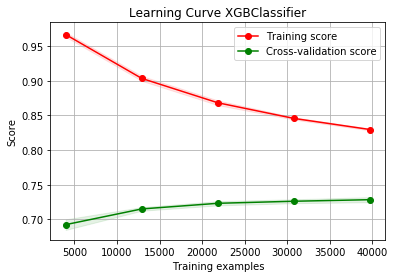

In [98]:
skplt.estimators.plot_learning_curve(model, X, y, cv=5, random_state=669,
                                     shuffle=True, scoring='roc_auc',
                                     title="Learning Curve XGBClassifier");

`I've managed to improve from from 0.724 to 0.727 at the expense of model stability. Gap between training and cross-validation score widend.`

[0]	validation_0-error:0.160374	validation_1-error:0.164619
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 12 rounds.
[20]	validation_0-error:0.157428	validation_1-error:0.159082
Stopping. Best iteration:
[21]	validation_0-error:0.157454	validation_1-error:0.15888

{'validation_0': {'error': [0.160374, 0.158712, 0.159291, 0.158838, 0.15841, 0.158662, 0.158309, 0.158511, 0.158335, 0.158108, 0.158058, 0.158335, 0.158385, 0.158586, 0.158209, 0.158158, 0.157932, 0.157781, 0.157705, 0.157655, 0.157428, 0.157454, 0.157504, 0.157454, 0.157151, 0.156925, 0.15695, 0.156724, 0.156774, 0.156673, 0.156623, 0.156547, 0.156573]}, 'validation_1': {'error': [0.164619, 0.161498, 0.160592, 0.160793, 0.160189, 0.16029, 0.16029, 0.159988, 0.160089, 0.16029, 0.160391, 0.160089, 0.159988, 0.159787, 0.159484, 0.159283, 0.159384, 0.159182, 0.159082, 0.158981, 0.159082, 0.15888, 0.159585, 0.159283, 0.159283, 

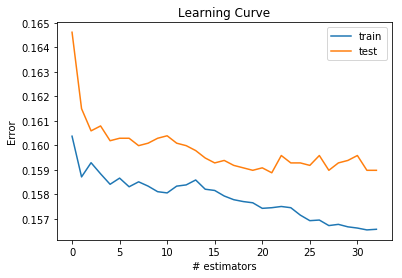

[0]	validation_0-error:0.159769	validation_1-error:0.165526
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 12 rounds.
Stopping. Best iteration:
[2]	validation_0-error:0.158033	validation_1-error:0.160391

{'validation_0': {'error': [0.159769, 0.157605, 0.158033, 0.157579, 0.157252, 0.157479, 0.157151, 0.157227, 0.157479, 0.15763, 0.157428, 0.157756, 0.157529, 0.157605]}, 'validation_1': {'error': [0.165526, 0.162203, 0.160391, 0.1617, 0.161498, 0.1617, 0.161498, 0.1618, 0.161599, 0.1617, 0.161095, 0.160793, 0.161095, 0.160592]}}



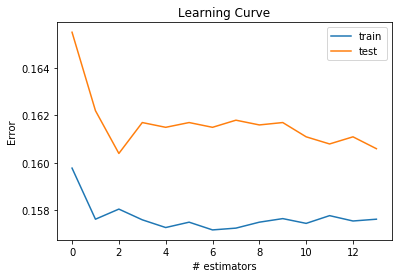

[0]	validation_0-error:0.15841	validation_1-error:0.161095
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 12 rounds.
Stopping. Best iteration:
[1]	validation_0-error:0.157756	validation_1-error:0.159686

{'validation_0': {'error': [0.15841, 0.157756, 0.158385, 0.157831, 0.158083, 0.158033, 0.157831, 0.158007, 0.157932, 0.158335, 0.158184, 0.158083, 0.157907]}, 'validation_1': {'error': [0.161095, 0.159686, 0.160793, 0.16029, 0.160189, 0.160189, 0.159787, 0.160693, 0.160089, 0.160592, 0.160391, 0.160089, 0.160089]}}



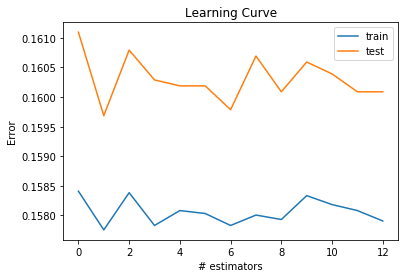

[0]	validation_0-error:0.159014	validation_1-error:0.160793
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 12 rounds.
Stopping. Best iteration:
[3]	validation_0-error:0.157504	validation_1-error:0.159988

{'validation_0': {'error': [0.159014, 0.158335, 0.158234, 0.157504, 0.157781, 0.157605, 0.157831, 0.157579, 0.157705, 0.157831, 0.157907, 0.157806, 0.157806, 0.157856, 0.157806]}, 'validation_1': {'error': [0.160793, 0.160793, 0.16029, 0.159988, 0.159988, 0.160391, 0.160693, 0.160793, 0.160491, 0.160592, 0.160391, 0.160793, 0.160592, 0.16029, 0.160391]}}



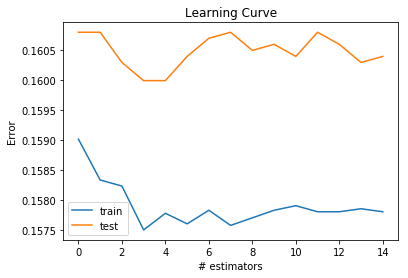

[0]	validation_0-error:0.159359	validation_1-error:0.162135
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 12 rounds.
Stopping. Best iteration:
[1]	validation_0-error:0.158427	validation_1-error:0.160222

{'validation_0': {'error': [0.159359, 0.158427, 0.158654, 0.158578, 0.158604, 0.158528, 0.158352, 0.158755, 0.158855, 0.158729, 0.158629, 0.158755, 0.158578]}, 'validation_1': {'error': [0.162135, 0.160222, 0.160524, 0.160926, 0.160826, 0.160826, 0.160322, 0.161027, 0.160926, 0.160826, 0.160624, 0.160926, 0.161128]}}



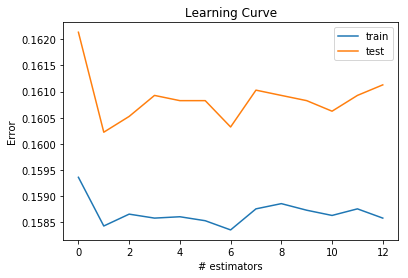

In [99]:
cv = StratifiedKFold(n_splits=5, random_state=669)

for train_idx, test_idx in cv.split(X, y):
    model = xgb.XGBClassifier(**hyper_params)
    # prepare eval_set
    eval_set = [
        (X[train_idx], y[train_idx]),
        (X[test_idx], y[test_idx])
    ]

    model.fit(X[train_idx], y[train_idx], eval_metric="error",
              eval_set=eval_set, verbose=20, early_stopping_rounds=12)
    # get evals result
    evals_result = model.evals_result()
    print(evals_result)
    print("")
    # plot
    plt.title("Learning Curve")
    plt.xlabel("# estimators")
    plt.ylabel("Error")
    plt.plot(model.evals_result_["validation_0"]["error"], label="train")
    plt.plot(model.evals_result_["validation_1"]["error"], label="test")
    plt.legend(loc="best")
    plt.show()

`I was considering letting data through pipeline, but it was a wrong idea.`

In [100]:
# pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
#                  ('scaler', MaxAbsScaler()),
#                  ('selector', SelectKBest(f_classif, k="all")),
#                  ('CF', model)])

In [101]:
# %time cv_model(pipe, X, y)

CPU times: user 2min 5s, sys: 304 ms, total: 2min 6s
Wall time: 2min 5s


(0.6889515542804268, 0.0016866175043248233)

In [108]:
scores = []
cv = StratifiedKFold(n_splits=5, random_state=669, shuffle=True)

for train_idx, test_idx in cv.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    scores.append(roc_auc_score(y[test_idx], y_pred))

    print(np.mean(scores), np.std(scores))

0.7258497078285504 0.0
0.7248797210402687 0.0009699867882817514
0.7305865292797464 0.008109412441353023
0.7311274061865225 0.00708516556566108
0.7285211720302327 0.008205454453222641


In [109]:
y_probas = model.predict_proba(X_test)
y_probas

array([[0.82957745, 0.17042252],
       [0.88245386, 0.11754612],
       [0.88443965, 0.11556036],
       ...,
       [0.8317582 , 0.16824178],
       [0.68693197, 0.31306803],
       [0.88075805, 0.11924198]], dtype=float32)

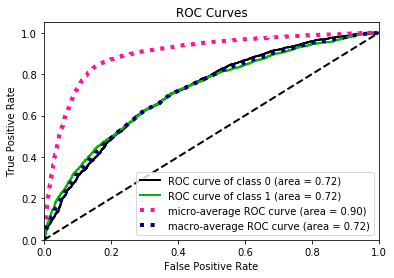

In [110]:
skplt.metrics.plot_roc(y_test, y_probas);

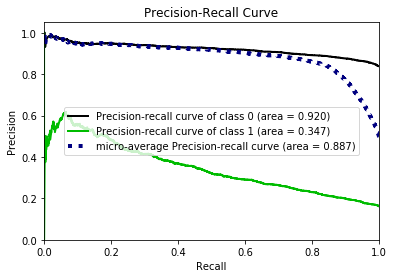

In [111]:
skplt.metrics.plot_precision_recall(y_test, y_probas);

**Submission preparation**

In [116]:
model.fit(X_train, y_train)
X_test = test_df[features].values
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
test_df['target'] = y_pred
test_df['target_score'] = y_pred_proba
test_df[['us_id', 'target', 'target_score']].to_csv(
    '../output/' + time.strftime("%Y%m%d_%H%M%S") + '.csv', index=False)

In [117]:
df = pd.read_csv('../output/20190721_083620.csv')
df.head()

,us_id,target,target_score
0,71092,0,0.462622
1,2259,0,0.253353
2,26129,0,0.138608
3,28155,0,0.059695
4,82400,0,0.165746


In [118]:
df.describe()

,us_id,target,target_score
count,16552.000000,16552.000000,16552.000000
mean,41184.065672,0.010875,0.152192
std,23984.111703,0.103717,0.095728
min,101.000000,0.000000,0.022858
25%,20217.500000,0.000000,0.087028
50%,41177.000000,0.000000,0.126500
75%,62026.500000,0.000000,0.184491
max,82861.000000,1.000000,0.800080


# Conclusions

Model made an assumption, that target == 1 when probability is >= 0.5

It seems to me that considering other threshold could be an option.

In case of determining who to send a newsletter in the future, the goal is to maximize recall, because in a worst case someone will get adverse email (This might be controversial, but after deliberation, that's the assumption I've took up on.)

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1.

True positive rate or recall, is the ratio between e-mail sent in the right time divided by sum of all and missed opportunities. In other words True positive rate will be 100% when, the amount of missed opportunities will be zero.